In [1]:
import hypothesis
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch.nn.utils import spectral_norm

In [2]:
mean_true = torch.tensor(1, dtype=torch.float)

normal = Normal(mean_true, 1.)
lower = torch.tensor(0, dtype=torch.float)
upper = torch.tensor(2, dtype=torch.float)
prior = Uniform(lower, upper)

In [3]:
def simulator(theta):
    normal = Normal(theta, 1)
    return normal.sample().view(-1)

In [26]:
from hypothesis.nn import ParameterizedClassifier
from hypothesis.nn import ParameterizedClassifierEnsemble

def allocate_classifier(hidden=256):
    classifier = torch.nn.Sequential(
        torch.nn.Linear(2, hidden),
        torch.nn.SELU(),
        spectral_norm(torch.nn.Linear(hidden, hidden)),
        torch.nn.SELU(),
        spectral_norm(torch.nn.Linear(hidden, hidden)),
        torch.nn.SELU(),
        spectral_norm(torch.nn.Linear(hidden, hidden)),
        torch.nn.SELU(),
        torch.nn.Linear(hidden, 1),
        torch.nn.Sigmoid())
    classifier = ParameterizedClassifier(classifier, lower=lower, upper=upper)
    classifier.train()
    
    return classifier

In [27]:
from hypothesis.io.dataset import GeneratorDataset as Dataset

dataset = Dataset(simulator, prior)

In [28]:
from hypothesis.train import ParameterizedClassifierTrainer as Trainer

def train():
    batch_size = 512
    classifier = allocate_classifier()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001)
    trainer = Trainer(classifier, dataset, optimizer, shuffle=True, epochs=30, batch_size=batch_size, criterion=torch.nn.BCELoss(reduction="mean"))
    trainer.train()
    classifier.eval()
    
    return classifier

In [36]:
num_classifiers = 5

#classifiers = []
for classifier_index in range(num_classifiers):
    print("Training classifier", classifier_index + 1)
    classifier = train()
    classifiers.append(classifier)

Training classifier 1
Training classifier 2
Training classifier 3
Training classifier 4
Training classifier 5


In [37]:
ensemble = ParameterizedClassifierEnsemble(classifiers)

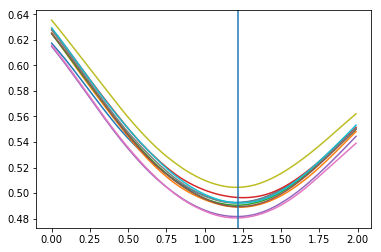

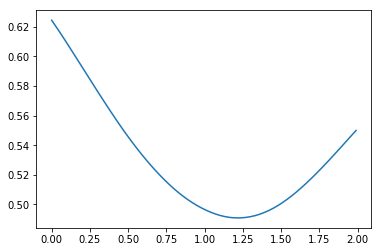

tensor(1.2200)
tensor(1.2173)


In [38]:
ensemble.eval()
thetas = torch.arange(lower, upper, 0.01)
samples = 128
observations = normal.sample(torch.Size([samples]))

ratios = []
for theta in thetas:
    theta = theta.repeat(samples)
    ratio = ensemble.forward_all(observations, theta).view(samples, -1).mean(dim=0).view(1, -1)
    #ratio = classifiers[3].forward(observations, theta).view(samples, -1).mean(dim=0).view(1, -1)
    ratios.append(ratio)

ratios = torch.cat(ratios, dim=0)
# Plot the estimated density function.
plt.plot(thetas.detach().numpy(), ratios.detach().numpy())
plt.axvline(observations.mean().numpy())
#plt.ylim([0, None])
plt.show()

m_ratio = ratios.mean(dim=1).detach()
plt.plot(thetas.detach().numpy(), m_ratio.numpy())
plt.show()

value, index = m_ratio.min(0)
print(thetas[index])
print(observations.mean())

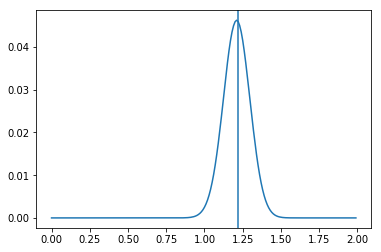

In [39]:
ensemble.eval()

ratios = []
for theta in thetas:
    ratio = ensemble.log_likelihood_to_evidence_ratio(observations, theta).view(-1)
    ratios.append(ratio)
    
ratios = torch.cat(ratios, dim=0).exp()
ratios /= ratios.sum()

plt.plot(thetas.detach().numpy(), ratios.detach().numpy())
plt.axvline(observations.mean())
#plt.axvline(mean_true)
#plt.ylim([0, None])
plt.show()